<a href="https://colab.research.google.com/github/madanmohan-venkatesan/notebooks/blob/main/2011_03567.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
from scipy.special import gamma
from scipy.optimize import minimize
from matplotlib import pyplot as plt
import seaborn as sns

# 2. A sequential multinomial test


In [2]:
#CONSTANTS
CLASSES=2
VECTOR_SIZE=100

In [3]:
theta_null=np.array([1/CLASSES]*CLASSES) #Simplex
rng = np.random.default_rng()
vectors_null=rng.multinomial(1,theta_null,size=VECTOR_SIZE)

In [4]:
K=100
alpha_dirichlet=K*theta_null
rng = np.random.default_rng()
theta_alt=rng.dirichlet(alpha_dirichlet)
vectors_alt=rng.multinomial(1,theta_alt,size=VECTOR_SIZE)

In [5]:
s_n_null=np.sum(vectors_null,axis=0)
s_n_alt=np.sum(vectors_alt,axis=0)

In [6]:
def beta(v):

  numerator=np.prod(gamma(v))
  denominator=gamma(np.sum(v))
  result=numerator/denominator
  if np.isnan(result).any():
    return np.array([np.inf])
  else:
    return result


In [7]:
def bf_10(dirichlet_alpha,theta,counts):
  term1_numerator=beta(dirichlet_alpha+counts)
  term1_denominator=beta(dirichlet_alpha)
  term1=term1_numerator/term1_denominator

  term2=1/(theta**counts)
  result=term1*term2

  if np.isnan(result).any() or np.isinf(result).any():
    return np.array([np.inf]*len(result))
  else:
    return result


In [8]:
bf_10(alpha_dirichlet,theta_null,s_n_alt)

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
<ipython-input-6-ffb25cde8259>:5: RuntimeWarning: invalid value encountered in scalar divide
  result=numerator/denominator


array([inf, inf])

For above bf_10, if theta_0 not equal theta then values will go to infinity (reject null hypothesis)
otherwise value is zero(accept null hypothesis)

Hyper paramters to play around with are K and vector size



In [9]:
theta_null_arr=[]
theta_alt_arr=[]
dirichlet_alpha_arr=[]
vetors_null_arr=[]
vectors_alt_arr=[]
for i in range(10):
  if i==0:
    K=10
  else:
    K=K#+(0.5*K)
  #generate null vectors
  theta_null=np.array([1/CLASSES]*CLASSES) #Simplex
  rng = np.random.default_rng()
  vectors_null=rng.multinomial(1,theta_null,size=VECTOR_SIZE)
  #generate alt vectors

  alpha_dirichlet=K*theta_null
  rng = np.random.default_rng()
  theta_alt=rng.dirichlet(alpha_dirichlet)
  vectors_alt=rng.multinomial(1,theta_alt,size=VECTOR_SIZE)

  theta_null_arr.append(theta_null)
  theta_alt_arr.append(theta_alt)
  dirichlet_alpha_arr.append(alpha_dirichlet)
  vetors_null_arr.append(vectors_null)
  vectors_alt_arr.append(vectors_alt)

In [10]:
on_theta_hist_arr=[]
for i in range(len(theta_null_arr)):
  on_theta_prev = None
  if i==0:
    on_theta_prev = np.array([1,1])
    on_theta_hist_arr.append(on_theta_prev)

  else:
    s_n_null=np.sum(vetors_null_arr[i],axis=0)
    s_n_alt=np.sum(vectors_alt_arr[i],axis=0)
    term1_numerator=beta(dirichlet_alpha_arr[i]+s_n_alt)
    term1_denominator=beta(dirichlet_alpha_arr[i])
    term1=term1_numerator/term1_denominator

    term2=1/(theta_null_arr[i]**s_n_alt)

    on_theta_hist_arr.append(on_theta_hist_arr[i-1]*term1*term2)

# Optimization problem for theta

In [11]:
def objective(theta, i,maximize=True):
    """
    Objective function to maximize theta_i.

    Parameters:
    - theta (array): Probability vector (simplex).
    - i (int): Index of the element to maximize.

    Returns:
    - float: Negative of theta[i] to convert minimization to maximization.
    """
    if maximize:
        return -theta[i]
    else:
      return theta[i]

def constraint_sum(theta):
    """
    Constraint ensuring that the sum of theta is 1.

    Parameters:
    - theta (array): Probability vector (simplex).

    Returns:
    - float: Sum of theta - 1 (should be 0).
    """
    return np.sum(theta) - 1

def constraint_log_likelihood(theta, Sn, c):
    """
    Log-likelihood constraint.

    Parameters:
    - theta (array): Probability vector (simplex).
    - Sn (array): Observed count vector S_{n,i}.
    - c (float): Constant c + log u.

    Returns:
    - float: Left-hand side of the constraint.
    """
    return np.sum(Sn * np.log(theta)) - c

# Real simulation

In [42]:
#CONSTANTS
CLASSES=2
VECTOR_SIZE=1000

theta_null=np.array([1/CLASSES]*CLASSES) #Simplex
rng = np.random.default_rng()
vectors_null=rng.multinomial(1,theta_null,size=VECTOR_SIZE)

K=10
alpha_dirichlet=K*theta_null
rng = np.random.default_rng()
theta_alt=rng.dirichlet(alpha_dirichlet)
vectors_alt=rng.multinomial(1,theta_alt,size=VECTOR_SIZE)


on_theta_hist_arr=[]
theta_alt_1max_arr=[]
theta_alt_1min_arr=[]

theta_alt_0max_arr=[]
theta_alt_0min_arr=[]

for i in range(0,VECTOR_SIZE,int(VECTOR_SIZE/100)):
  on_theta_prev = None
  vectors_null_i=[]
  vectors_alt_i=[]
  if i==0:
    on_theta_prev = np.array([1]*CLASSES)
    vectors_null_i=vectors_null[i]
    vectors_alt_i=vectors_alt[i]
    on_theta_hist_arr.append(on_theta_prev)
  else:
    vectors_null_i=vectors_null[:i]
    vectors_alt_i=vectors_alt[:i]

  s_n_null=np.sum(vectors_null_i,axis=0)
  s_n_alt=np.sum(vectors_alt_i,axis=0)

  term1_numerator=beta(alpha_dirichlet+s_n_alt)
  term1_denominator=beta(alpha_dirichlet)
  term1=term1_numerator/term1_denominator

  term2=1/(theta_null**s_n_alt)
  on_theta_curr=on_theta_hist_arr[-1]*term1*term2
  on_theta_hist_arr.append(on_theta_curr)
  if (on_theta_curr.any() >= 1/0.05) or (np.isnan(on_theta_curr).any()):
    print("Reject null hypothesis")
    break
  else:
    print("Accept null hypothesis")

  c = np.log(beta(alpha_dirichlet+s_n_alt)) - np.log(beta(alpha_dirichlet))  # Example constant for log Beta terms
  u = 0.05  # Example confidence level
  c += np.log(u)

  # Initial guess for theta (uniform distribution)
  initial_theta = np.full(len(theta_alt), 1 / len(theta_alt))

  # Constraints
  constraints = [
      {'type': 'eq', 'fun': constraint_sum},
      {'type': 'ineq', 'fun': constraint_log_likelihood, 'args': (s_n_alt, c)}
  ]

  # Bounds to ensure theta remains within [0, 1]
  bounds = [(0, 1) for _ in range(len(theta_alt))]

  # Solve the optimization problem
  result0 = minimize(objective, initial_theta, args=(0,True), bounds=bounds, constraints=constraints, method='SLSQP')
  result1 = minimize(objective, initial_theta, args=(1,True), bounds=bounds, constraints=constraints, method='SLSQP')

  # Display the result
  if result0.success:
      theta_alt_0max_arr.append(result0.x[0])
  else:
      print("Optimization failed:", result0.message)

  if result1.success:
      theta_alt_1max_arr.append(result1.x[0])
  else:
      print("Optimization failed:", result1.message)




  # Solve the optimization problem

  result0 = minimize(objective, initial_theta, args=(0,False), bounds=bounds, constraints=constraints, method='SLSQP')
  result1 = minimize(objective, initial_theta, args=(1,False), bounds=bounds, constraints=constraints, method='SLSQP')

  # Display the result
  if result0.success:
      theta_alt_0min_arr.append(result0.x[0])
  else:
      print("Optimization failed:", result0.message)

  if result1.success:
      theta_alt_1min_arr.append(result1.x[0])
  else:
      print("Optimization failed:", result1.message)

Accept null hypothesis
Accept null hypothesis
Accept null hypothesis
Accept null hypothesis
Accept null hypothesis
Accept null hypothesis
Accept null hypothesis
Accept null hypothesis
Accept null hypothesis
Accept null hypothesis
Accept null hypothesis
Accept null hypothesis
Accept null hypothesis
Accept null hypothesis
Accept null hypothesis
Accept null hypothesis
Accept null hypothesis
Accept null hypothesis
Optimization failed: Inequality constraints incompatible
Optimization failed: Inequality constraints incompatible
Optimization failed: Inequality constraints incompatible
Optimization failed: Inequality constraints incompatible
Reject null hypothesis


<ipython-input-42-20da57a046fb>:52: RuntimeWarning: divide by zero encountered in log
  c = np.log(beta(alpha_dirichlet+s_n_alt)) - np.log(beta(alpha_dirichlet))  # Example constant for log Beta terms
<ipython-input-6-ffb25cde8259>:5: RuntimeWarning: invalid value encountered in scalar divide
  result=numerator/denominator
<ipython-input-42-20da57a046fb>:44: RuntimeWarning: invalid value encountered in multiply
  on_theta_curr=on_theta_hist_arr[-1]*term1*term2


In [43]:
theta_alt

array([0.23385133, 0.76614867])

In [44]:
on_theta_hist_arr
p_value_arr=1/np.array(on_theta_hist_arr)
p_clip=[]
for i in range(len(p_value_arr)):
  if i==0:
    p_clip.append(np.array([1]*CLASSES))
  else:
    p_clip.append(np.clip(p_value_arr[i],p_value_arr[i],p_clip[i-1]))
p_clip

<ipython-input-44-be7e41f18bd5>:2: RuntimeWarning: divide by zero encountered in divide
  p_value_arr=1/np.array(on_theta_hist_arr)


[array([1, 1]),
 array([1., 1.]),
 array([1., 1.]),
 array([1.       , 0.4616992]),
 array([1.        , 0.00268746]),
 array([1.00000000e+00, 1.14778448e-06]),
 array([1.00000000e+00, 3.18824559e-10]),
 array([1.00000000e+00, 5.64615423e-14]),
 array([1.00000000e+00, 6.66774586e-20]),
 array([1.00000000e+00, 5.06341724e-25]),
 array([1.00000000e+00, 2.40722064e-30]),
 array([1.0000000e+00, 6.3205196e-35]),
 array([1.00000000e+00, 1.01327655e-39]),
 array([1.0000000e+00, 9.8772545e-45]),
 array([1.00000000e+00, 5.83391964e-50]),
 array([1.00000000e+00, 2.40852159e-56]),
 array([1.00000000e+00, 6.71634228e-64]),
 array([1.00000000e+00, 7.15618624e-69]),
 array([1.00000000e+00, 7.15618624e-69]),
 array([nan, nan])]

In [45]:
print(len(on_theta_hist_arr))
print(len(theta_alt_1max_arr))
print(len(theta_alt_1min_arr))
print(len(theta_alt_0max_arr))
print(len(theta_alt_0min_arr))




20
17
17
17
17


ValueError: x and y must have same first dimension, but have shapes (17,) and (19,)

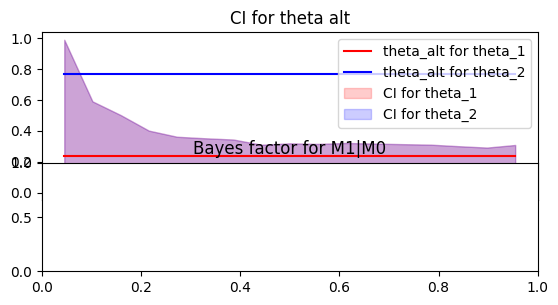

In [47]:
plt.subplot(2,1,1)
plt.title("CI for theta alt")
lenght=len(theta_alt_0min_arr)
plt.plot(range(lenght),[theta_alt[0]]*lenght,color='r',label="theta_alt for theta_1")
plt.plot(range(lenght),[theta_alt[1]]*lenght,color='b',label="theta_alt for theta_2")

plt.fill_between(range(lenght),
                 np.array(theta_alt_0min_arr),
                 np.array(theta_alt_0max_arr), color='r',
                 alpha=0.2, label="CI for theta_1")  # alpha controls transparency


plt.fill_between(range(lenght),
                 np.array(theta_alt_1min_arr),
                 np.array(theta_alt_1max_arr), color='b',
                 alpha=0.2, label="CI for theta_2")  # alpha controls transparency


# plt.plot(range(len(theta_alt_arr)),np.array(theta_alt_min_arr)[:,0],label="theta_alt min for theta_1")
# plt.plot(range(len(theta_alt_arr)),np.array(theta_alt_max_arr)[:,0],label="theta_alt max for theta_1")
# plt.plot(range(len(theta_alt_arr)),np.array(theta_alt_min_arr)[:,1],label="theta_alt min for theta_2")
# plt.plot(range(len(theta_alt_arr)),np.array(theta_alt_max_arr)[:,1],label="theta_alt max for theta_2")

plt.legend()
plt.subplot(3,1,2)
plt.title("Bayes factor for M1|M0")
plt.plot(range(lenght),np.array(p_clip)[:-1,0],color='r',label="Bayes factor for theta 1")
plt.plot(range(lenght),[0.05]*lenght,'--',color='b',label="0.05")
plt.legend()
plt.plot()


plt.subplot(3,1,3)
plt.title("Bayes factor for M1|M0")
plt.plot(range(lenght),np.array(p_clip)[:-1,1],color='r',label="Bayes factor for theta 2")
plt.plot(range(lenght),[0.05]*lenght,'--',color='b',label="0.05")
plt.legend()
plt.plot()

In [17]:
np.round(theta_alt_0min_arr,3)

array([0.011])

In [18]:
np.round(theta_alt_1min_arr,3)

array([0.989])

In [19]:
np.round(theta_alt_1max_arr,3)

array([0.011])

In [20]:
np.round(theta_alt_0max_arr,3)

array([0.989])

In [21]:
1/np.array(on_theta_hist_arr) < (1/0.05)

array([[ True,  True],
       [ True,  True]])

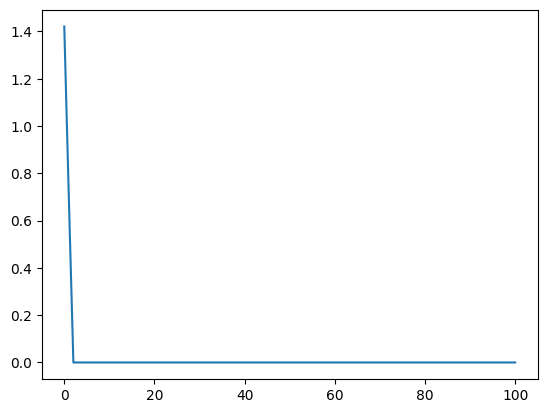

In [22]:
from scipy.stats import gaussian_kde

event_timestamps=np.array([1,2])
kde=gaussian_kde(vectors_alt[:100,1])
time_points=np.linspace(0,100,100)
plt.plot(time_points,kde(time_points))

In [23]:
time_points

array([  0.        ,   1.01010101,   2.02020202,   3.03030303,
         4.04040404,   5.05050505,   6.06060606,   7.07070707,
         8.08080808,   9.09090909,  10.1010101 ,  11.11111111,
        12.12121212,  13.13131313,  14.14141414,  15.15151515,
        16.16161616,  17.17171717,  18.18181818,  19.19191919,
        20.2020202 ,  21.21212121,  22.22222222,  23.23232323,
        24.24242424,  25.25252525,  26.26262626,  27.27272727,
        28.28282828,  29.29292929,  30.3030303 ,  31.31313131,
        32.32323232,  33.33333333,  34.34343434,  35.35353535,
        36.36363636,  37.37373737,  38.38383838,  39.39393939,
        40.4040404 ,  41.41414141,  42.42424242,  43.43434343,
        44.44444444,  45.45454545,  46.46464646,  47.47474747,
        48.48484848,  49.49494949,  50.50505051,  51.51515152,
        52.52525253,  53.53535354,  54.54545455,  55.55555556,
        56.56565657,  57.57575758,  58.58585859,  59.5959596 ,
        60.60606061,  61.61616162,  62.62626263,  63.63

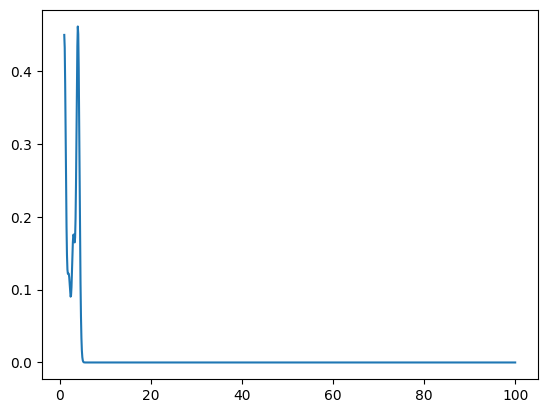

In [24]:
num_time_points=100
probabilities=np.random.dirichlet(alpha=[1,2,3,4],size=1).flatten()
num_samples=1000
event_times=np.random.choice(np.arange(1,5),size=num_samples,p=probabilities/np.sum(probabilities))
kde=gaussian_kde(event_times,bw_method='scott')
time_grid=np.linspace(1,num_time_points,1000)
mu_t=kde(time_grid)
plt.plot(time_grid,mu_t)
